In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("/kaggle/input/online-payment-fraud-detection/onlinefraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
598351,33,PAYMENT,8153.87,C1835145778,0.00,0.00,M1077706096,0.00,0.00,0,0
1532492,154,CASH_OUT,69037.14,C1654542349,81801.00,12763.86,C1842951570,204360.10,273397.24,0,0
4428277,322,CASH_OUT,78944.54,C1524338743,0.00,0.00,C1871059223,2257301.13,2336245.66,0,0
5392461,377,PAYMENT,9664.03,C1986587124,0.00,0.00,M718949258,0.00,0.00,0,0
4004872,298,PAYMENT,25807.16,C1963123840,154674.00,128866.84,M989772766,0.00,0.00,0,0
1275604,135,CASH_IN,236749.44,C2064156723,936783.17,1173532.61,C120570672,302426.57,65677.13,0,0
2419921,202,PAYMENT,3932.41,C1804038938,2211.00,0.00,M1334709144,0.00,0.00,0,0
1574478,155,CASH_IN,160362.00,C1385042784,5392230.81,5552592.82,C1308472584,3201986.42,3041624.42,0,0
3948534,287,CASH_IN,176687.99,C663307487,0.00,176687.99,C1100685336,1904775.36,1728087.36,0,0
2917840,229,PAYMENT,45405.61,C727528109,303682.00,258276.39,M198366092,0.00,0.00,0,0


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Feature engineering 
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] 
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [11]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [12]:
df['nameOrig'].value_counts()

nameOrig
C1530544995    3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
              ..
C1567523029    1
C644777639     1
C1256645416    1
C1231536757    1
C1971151096    1
Name: count, Length: 6353307, dtype: int64

In [13]:
df['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
              ... 
M295304806       1
M33419717        1
M1940055334      1
M335107734       1
M1757317128      1
Name: count, Length: 2722362, dtype: int64

In [14]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
245        4
28         4
655        4
112        2
662        2
Name: count, Length: 743, dtype: int64

In [15]:
df['amount'].value_counts()

amount
10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
20464.65          1
26299.05          1
401295.63         1
499807.64         1
1136700.07        1
Name: count, Length: 5316900, dtype: int64

In [16]:
df['oldbalanceOrg'].value_counts()

oldbalanceOrg
0.00         2102449
184.00           918
133.00           914
195.00           912
164.00           909
              ...   
87528.25           1
42686.88           1
32023.32           1
173464.47          1
5737.49            1
Name: count, Length: 1845844, dtype: int64

In [17]:
df['newbalanceOrig'].value_counts()

newbalanceOrig
0.00          3609566
26099.09            4
3684.32             4
18672.58            4
38767.21            4
               ...   
1156489.06          1
44707.62            1
29850.29            1
2251.93             1
165200.06           1
Name: count, Length: 2682586, dtype: int64

In [18]:
df['oldbalanceDest'].value_counts()

oldbalanceDest
0.00           2704388
10000000.00        615
20000000.00        219
30000000.00         86
40000000.00         31
                ...   
2039554.04           1
587552.25            1
1326910.11           1
230693.29            1
851586.36            1
Name: count, Length: 3614697, dtype: int64

In [19]:
df['newbalanceDest'].value_counts()

newbalanceDest
0.00           2439433
10000000.00         53
971418.91           32
19169204.93         29
16532032.16         25
                ...   
1347758.15           1
3878719.83           1
1605826.83           1
592930.77            1
2580880.68           1
Name: count, Length: 3555499, dtype: int64

In [20]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [21]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [22]:
df['balanceDiffOrig']

0             9839.64
1             1864.28
2              181.00
3              181.00
4            11668.14
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: balanceDiffOrig, Length: 6362620, dtype: float64

In [23]:
df['balanceDiffDest']

0                0.00
1                0.00
2                0.00
3           -21182.00
4                0.00
              ...    
6362615     339682.13
6362616          0.00
6362617    6311409.27
6362618          0.00
6362619     850002.52
Name: balanceDiffDest, Length: 6362620, dtype: float64

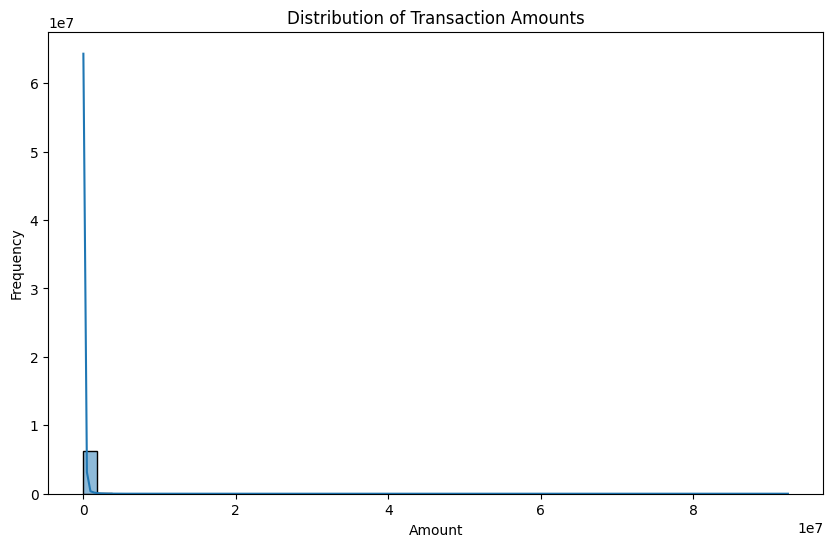

In [24]:
# Distribution of transaction amounts 
plt.figure(figsize=(10, 6)) 
sns.histplot(df['amount'], bins=50, kde=True) 
plt.title('Distribution of Transaction Amounts') 
plt.xlabel('Amount') 
plt.ylabel('Frequency') 
plt.show()

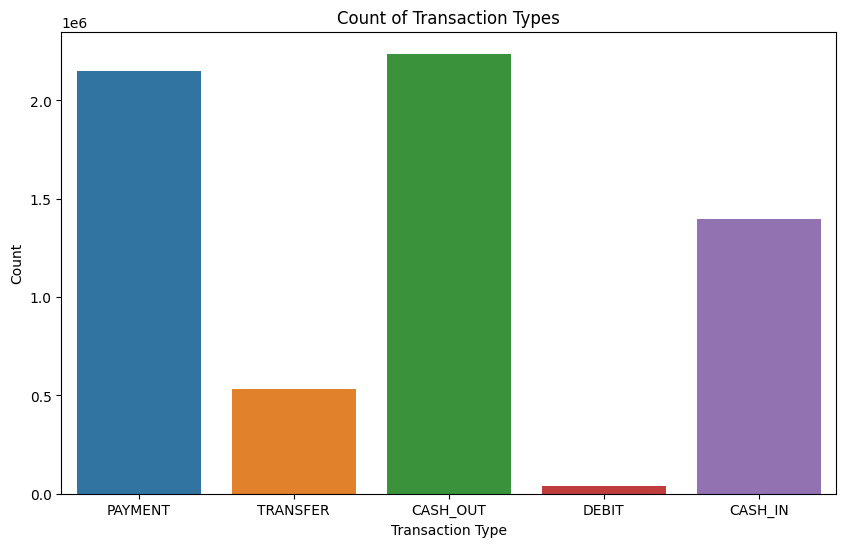

In [25]:
# Count of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

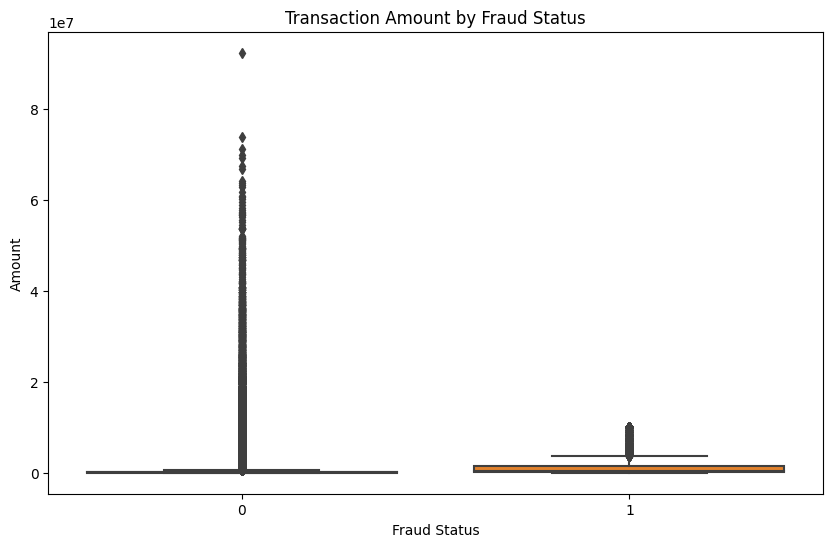

In [26]:
# Boxplot of transaction amount by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Amount')
plt.show()


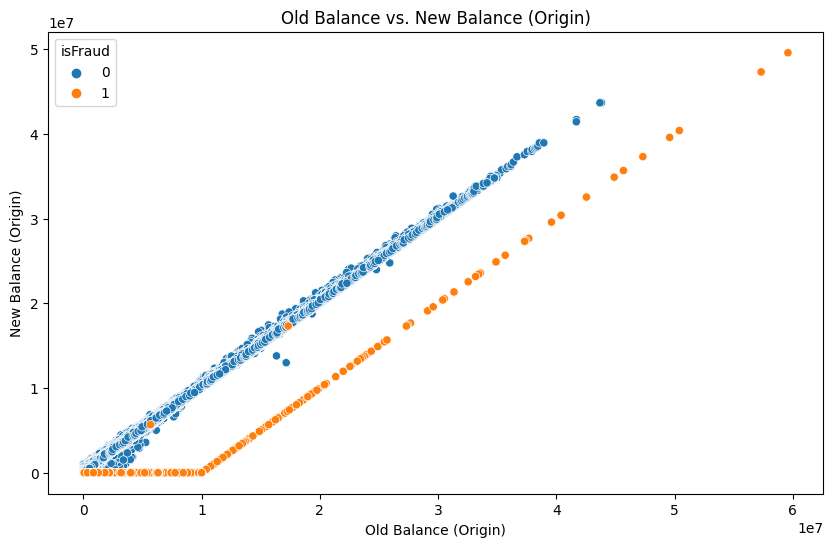

In [27]:
# Scatter plot of old vs new balance for origin 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', data=df) 
plt.title('Old Balance vs. New Balance (Origin)') 
plt.xlabel('Old Balance (Origin)') 
plt.ylabel('New Balance (Origin)') 
plt.show()

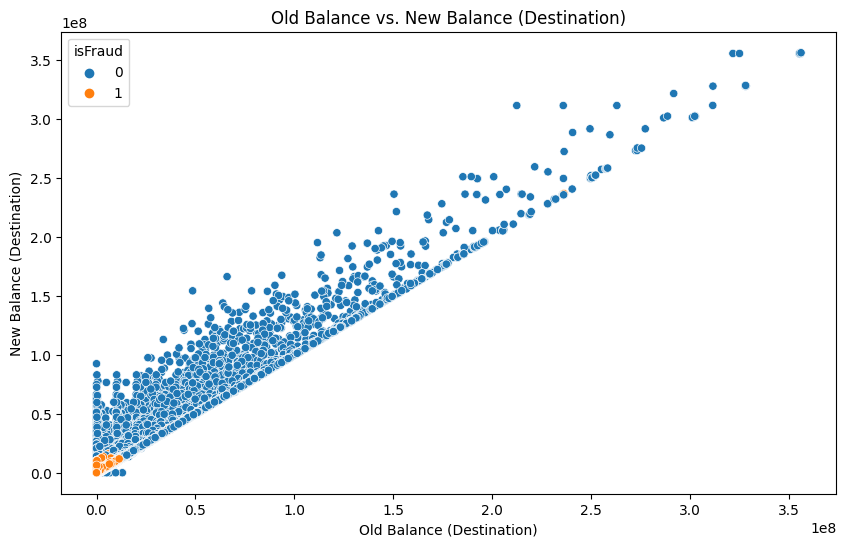

In [28]:
# Scatter plot of old vs new balance for destination 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='oldbalanceDest', y='newbalanceDest', hue='isFraud', data=df) 
plt.title('Old Balance vs. New Balance (Destination)') 
plt.xlabel('Old Balance (Destination)') 
plt.ylabel('New Balance (Destination)')
plt.show()

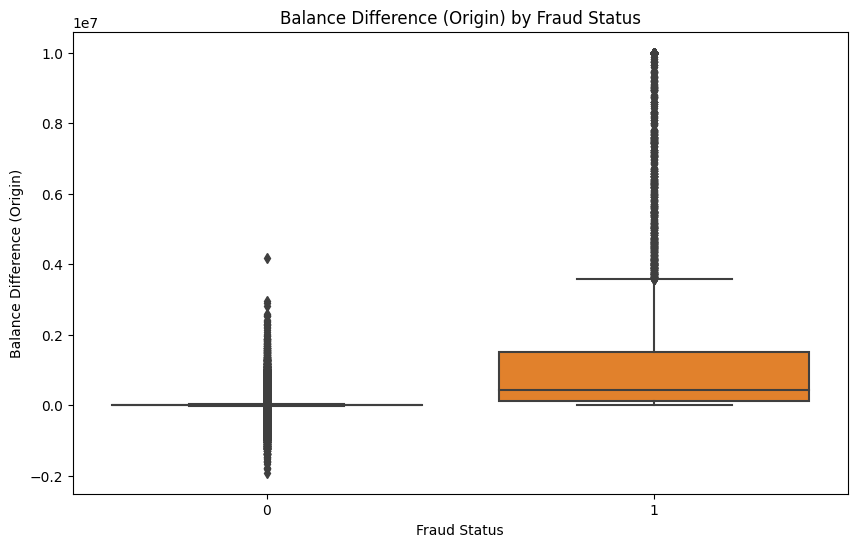

In [29]:
# Compute balance differences
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] 
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Boxplot of balance differences by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='balanceDiffOrig', data=df)
plt.title('Balance Difference (Origin) by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Balance Difference (Origin)')
plt.show()

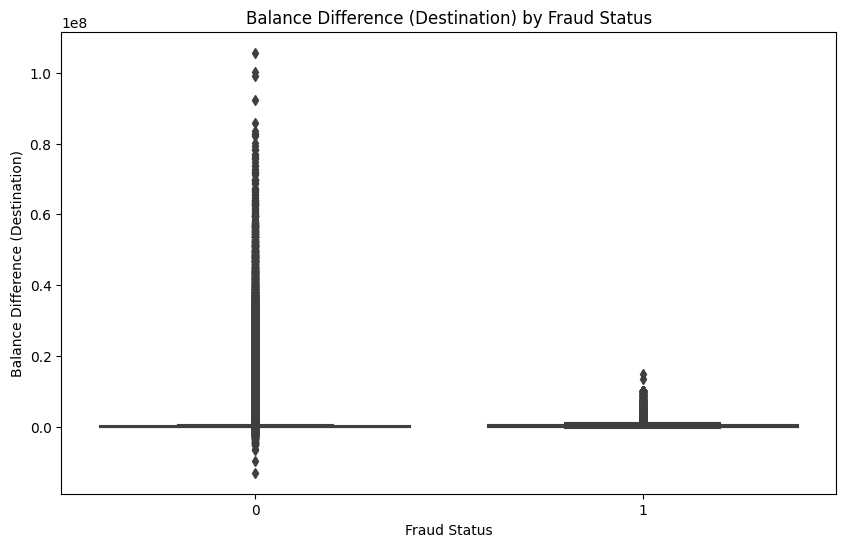

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='balanceDiffDest', data=df)
plt.title('Balance Difference (Destination) by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Balance Difference (Destination)')
plt.show()

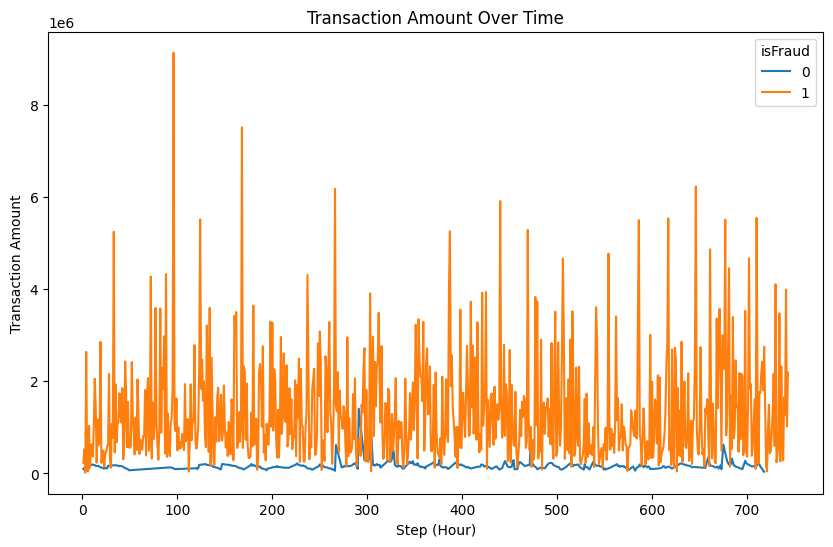

In [31]:
# Transaction count over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='step', y='amount', hue='isFraud', data=df, ci=None)
plt.title('Transaction Amount Over Time')
plt.xlabel('Step (Hour)')
plt.ylabel('Transaction Amount')
plt.show()

In [32]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [33]:
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])
df['type'].value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

In [34]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [35]:
features = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','balanceDiffOrig','balanceDiffDest','type','isFlaggedFraud']
target = 'isFraud'

In [36]:
x = df[features]
y = df[target]

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# KEY FEATURES OF XB BOOST


# XGBoost Classifier: XGBoost stands for Extreme Gradient Boosting, and it is an optimized version of the Gradient Boosting Machine (GBM) technique. It's designed to be highly efficient, flexible, and portable, and it has become one of the most popular machine learning algorithms for structured/tabular data.



# Boosting:XGBoost is a boosting algorithm that builds an ensemble of decision trees sequentially. Each tree tries to correct the errors of the previous one, resulting in a strong predictive model


# Regularization:It includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting, making it more robust than traditional GBM.



# Tree Pruning:Uses a technique called "max depth" rather than "max leaf nodes" to prune trees. It also employs a heuristic called "approximate greedy algorithm" to find the best split.



# Handling Missing Values:It automatically handles missing values during training, making it efficient for real-world datasets.



# Parallelization:XGBoost supports parallel and distributed computing, significantly speeding up the training process


# Early Stopping:Allows for early stopping if the model performance on a validation set starts to deteriorate.


In [38]:
# Train an XGBoost classifier 
model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1) 
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
# Make predictions 
y_pred = model.predict(x_test) 
y_pred_proba = model.predict_proba(x_test)[:, 1] 

In [40]:
# Evaluate model 
print(classification_report(y_test, y_pred)) 
print("ROC-AUC Score:", roc_auc_score(y_test,y_pred))
print("accuracy:",accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.77      0.86      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.884381923297635
accuracy: 0.9996804251498073


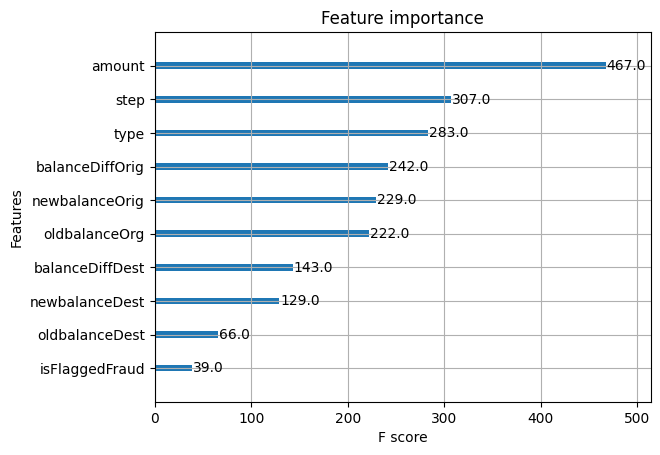

In [41]:
from xgboost import plot_importance
# Plot feature importance 
plot_importance(model) 
plt.show()

PR-AUC Score: 0.9332
Average Precision Score: 0.9332


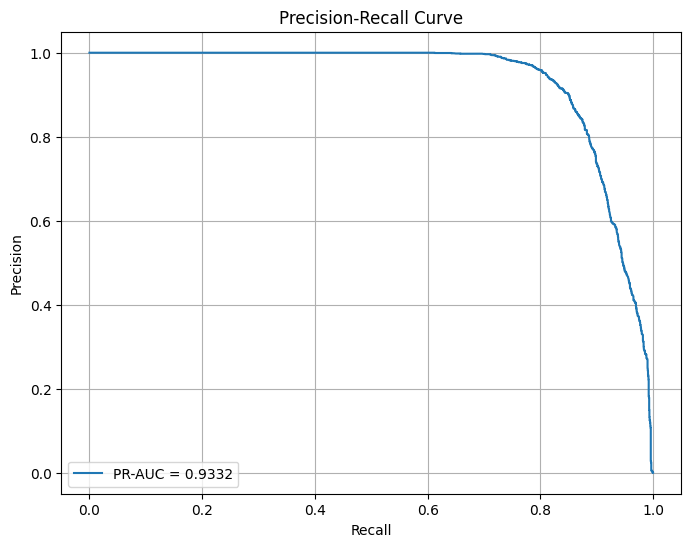

In [43]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs = model.predict_proba(x_test)[:, 1]  # assuming X_test is your test set

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)  # assuming y_test is your true labels

# Calculate PR-AUC
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_probs)

print(f"PR-AUC Score: {pr_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")

# Optional: Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import pandas as pd

# Load your dataset (if not already loaded)
# df = pd.read_csv('your_dataset.csv')  # Uncomment and edit if needed

# Check class distribution
class_counts = df['isFraud'].value_counts()  # Replace 'fraud' with your actual target column name

print("Class distribution:")
print(class_counts)

# Calculate ratio
if 0 in class_counts.index and 1 in class_counts.index:
    ratio = class_counts[0] / class_counts[1]
    print(f"\nClass 0:1 ratio = {int(ratio)} : 1")
else:
    print("\nError: dataset does not contain both classes 0 and 1.")


Class distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Class 0:1 ratio = 773 : 1


In [45]:
from sklearn.metrics import roc_curve

# Get predicted probabilities
y_scores = model.predict_proba(x_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find the recall (TPR) where FPR is closest to 0.005 (0.5%)
target_fpr = 0.005
idx = (fpr >= target_fpr).argmax()

print(f"Recall at {fpr[idx]*100:.3f}% FPR: {tpr[idx]:.4f}")


Recall at 0.500% FPR: 0.9922


In [46]:
import joblib

joblib.dump(model, 'model.pkl')


['model.pkl']